In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score

# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import regularizers
# from keras import initializers
# from keras.layers import BatchNormalization
# from tensorflow.keras.constraints import MaxNorm
# from kerastuner.tuners import Hyperband

# from tensorflow.keras.optimizers import Adam

# import shap
# from lime import lime_tabular


In [19]:
train = pd.read_csv('data/train.csv')
train_extra = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')
train_noisy = pd.read_csv('data/Noisy_Student_Bag_Price_Prediction_Dataset.csv')


In [20]:
train = pd.concat([train, train_extra], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### NaN Treatment

In [21]:
train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [22]:
print(train.isna().sum().sum())

cat_cols = [col for col in train.columns if train[col].dtype not in ['float64', 'int64']]

train[cat_cols] = train[cat_cols].fillna('Unknown')
test[cat_cols] = test[cat_cols].fillna('Unknown')


print(train.isna().sum().sum())

757967
1808


In [23]:
# impute weight capacity
train.fillna({'Weight Capacity (kg)': train['Weight Capacity (kg)'].mean()}, inplace=True)

### Merge Extra set

In [24]:
train_noisy = train_noisy.loc[(train_noisy["Weight Capacity (kg)"]>5)&(train_noisy["Weight Capacity (kg)"]<30)]
train_noisy.columns = [f"orig_{c}" for c in train_noisy.columns]
train = train.merge(train_noisy, left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")
train = train.drop("id",axis=1)
test = test.merge(train_noisy, left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")
train.head()


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,orig_Brand,orig_Material,orig_Size,orig_Compartments,orig_Laptop Compartment,orig_Waterproof,orig_Style,orig_Color,orig_Weight Capacity (kg),orig_Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,Puma,Nylon,Small,7.0,No,Yes,Tote,Black,11.611723,39.770555
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add more engineered features

In [25]:
cat_cols.append('Compartments')

In [ ]:
COMBO = []
for i,c in enumerate(cat_cols):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_wc"
    train[n] = train[c]*100 + train["Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["Weight Capacity (kg)"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )


We engineer 8 new columns!
['Brand_wc', 'Material_wc', 'Size_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'Compartments_wc']


### More Features with K-folds

In [27]:
train.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price',
       'orig_Brand', 'orig_Material', 'orig_Size', 'orig_Compartments',
       'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style',
       'orig_Color', 'orig_Weight Capacity (kg)', 'orig_Price', 'Brand_wc',
       'Material_wc', 'Size_wc', 'Laptop Compartment_wc', 'Waterproof_wc',
       'Style_wc', 'Color_wc', 'Compartments_wc'],
      dtype='object')

In [28]:

orig_cols = [col for col in train.columns if 'orig_' in col]
FEATURES = cat_cols + ["Weight Capacity (kg)"] + COMBO  + orig_cols
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

We now have 27 columns:
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Compartments', 'Weight Capacity (kg)', 'Brand_wc', 'Material_wc', 'Size_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'Compartments_wc', 'orig_Brand', 'orig_Material', 'orig_Size', 'orig_Compartments', 'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style', 'orig_Color', 'orig_Weight Capacity (kg)', 'orig_Price']


In [29]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [30]:
CATS = cat_cols

In [32]:
train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,...,orig_Weight Capacity (kg),orig_Price,Brand_wc,Material_wc,Size_wc,Laptop Compartment_wc,Waterproof_wc,Style_wc,Color_wc,Compartments_wc
0,0,0,0,0,0,0,0,0,11.611723,112.15875,...,11.611723,39.770555,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723
1,0,1,1,1,0,1,1,1,27.078537,68.88056,...,NaN,NaN,27.078537,127.078537,127.078537,27.078537,127.078537,127.078537,127.078537,127.078537
2,1,0,1,2,0,0,1,2,16.643760,39.17320,...,NaN,NaN,116.643760,16.643760,116.643760,16.643760,16.643760,116.643760,216.643760,216.643760
3,2,2,1,3,0,0,1,1,12.937220,80.60793,...,NaN,NaN,212.937220,212.937220,112.937220,12.937220,12.937220,112.937220,112.937220,312.937220
4,3,1,0,4,0,1,1,1,17.749338,86.02312,...,NaN,NaN,317.749338,117.749338,17.749338,17.749338,117.749338,117.749338,117.749338,417.749338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,2,1,3,5,0,1,1,3,28.098120,104.74460,...,NaN,NaN,228.098120,128.098120,328.098120,28.098120,128.098120,128.098120,328.098120,528.098120
3994314,4,0,1,1,0,1,0,3,17.379531,122.39043,...,17.379531,74.027653,417.379531,17.379531,117.379531,17.379531,117.379531,17.379531,317.379531,117.379531
3994315,0,1,2,1,1,0,3,2,17.037708,148.18470,...,17.037708,150.000000,17.037708,117.037708,217.037708,117.037708,17.037708,317.037708,217.037708,117.037708
3994316,4,1,3,2,1,0,3,4,28.783339,22.32269,...,NaN,NaN,428.783339,128.783339,328.783339,128.783339,28.783339,328.783339,428.783339,228.783339


In [33]:
# Constants
FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Out-of-Fold and Test Predictions
oof = np.zeros(len(train))
pred = np.zeros(len(test))

# Outer K-Fold Loop
for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")
    
    print(train.columns)
    # Split Data
    X_train, y_train = train.loc[train_idx, FEATURES], train.loc[train_idx, 'Price']
    X_valid, y_valid = train.loc[valid_idx, FEATURES], train.loc[valid_idx, 'Price']
    X_test = test[FEATURES]

    # Inner K-Fold for Target Encoding
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    for j, (train_idx2, valid_idx2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2, y_train2 = X_train.iloc[train_idx2], y_train.iloc[train_idx2]
        X_valid2 = X_train.iloc[valid_idx2]

        # Feature Set 1: Target Encoding on Weight Capacity
        col = "Weight Capacity (kg)"
        te1 = X_train2.groupby(col)['Price'].agg(STATS).rename(
            columns=lambda x: f"TE1_wc_{x}"
        )
        X_valid2 = X_valid2.merge(te1, on=col, how="left")
        X_train.loc[valid_idx2, te1.columns] = X_valid2[te1.columns]

        # Feature Set 2: Target Encoding on Combo Columns
        for col in COMBO:
            te2 = X_train2.groupby(col)['Price'].agg(STATS2).rename(
                columns=lambda x: f"TE2_{col}_{x}"
            )
            X_valid2 = X_valid2.merge(te2, on=col, how="left")
            X_train.loc[valid_idx2, te2.columns] = X_valid2[te2.columns]

    # Apply Target Encoding to Validation & Test Sets
    te1 = X_train.groupby("Weight Capacity (kg)")['Price'].agg(STATS).rename(
        columns=lambda x: f"TE1_wc_{x}"
    )
    X_valid = X_valid.merge(te1, on="Weight Capacity (kg)", how="left")
    X_test = X_test.merge(te1, on="Weight Capacity (kg)", how="left")

    for col in COMBO:
        te2 = X_train.groupby(col)['Price'].agg(STATS2).rename(
            columns=lambda x: f"TE2_{col}_{x}"
        )
        X_valid = X_valid.merge(te2, on=col, how="left")
        X_test = X_test.merge(te2, on=col, how="left")

    # Feature Set 3: Feature Engineering (Without Price)
    for col in CATS:
        fe3 = X_train.groupby(col)["Weight Capacity (kg)"].agg(STATS2).rename(
            columns=lambda x: f"FE3_{col}_wc_{x}"
        )
        X_train = X_train.merge(fe3, on=col, how="left")
        X_valid = X_valid.merge(fe3, on=col, how="left")
        X_test = X_test.merge(fe3, on=col, how="left")

    # Convert Categorical Features for CatBoost
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # Drop Price Column (Used for Target Encoding)
    X_train.drop(columns=['Price'], inplace=True)

    # Define and Train CatBoost Model
    model = CatBoostRegressor(
        depth=6,
        l2_leaf_reg=3,  
        iterations=10_000,  
        learning_rate=0.02,  
        subsample=0.8,
        random_seed=42,
        cat_features=CATS,
        verbose=300,
        early_stopping_rounds=100,
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True,
    )

    # Predict OOF and Test
    oof[valid_idx] = model.predict(X_valid)
    pred += model.predict(X_test)

# Average Predictions
pred /= FOLDS

### OUTER Fold 1 ###
Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price',
       'orig_Brand', 'orig_Material', 'orig_Size', 'orig_Compartments',
       'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style',
       'orig_Color', 'orig_Weight Capacity (kg)', 'orig_Price', 'Brand_wc',
       'Material_wc', 'Size_wc', 'Laptop Compartment_wc', 'Waterproof_wc',
       'Style_wc', 'Color_wc', 'Compartments_wc'],
      dtype='object')
 ## INNER Fold 1 (outer fold 1) ##


KeyError: 'Column not found: Price'

### Overall CV

In [49]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")


=> Overall CV Score = 38.64968078761826


### Feature Importance

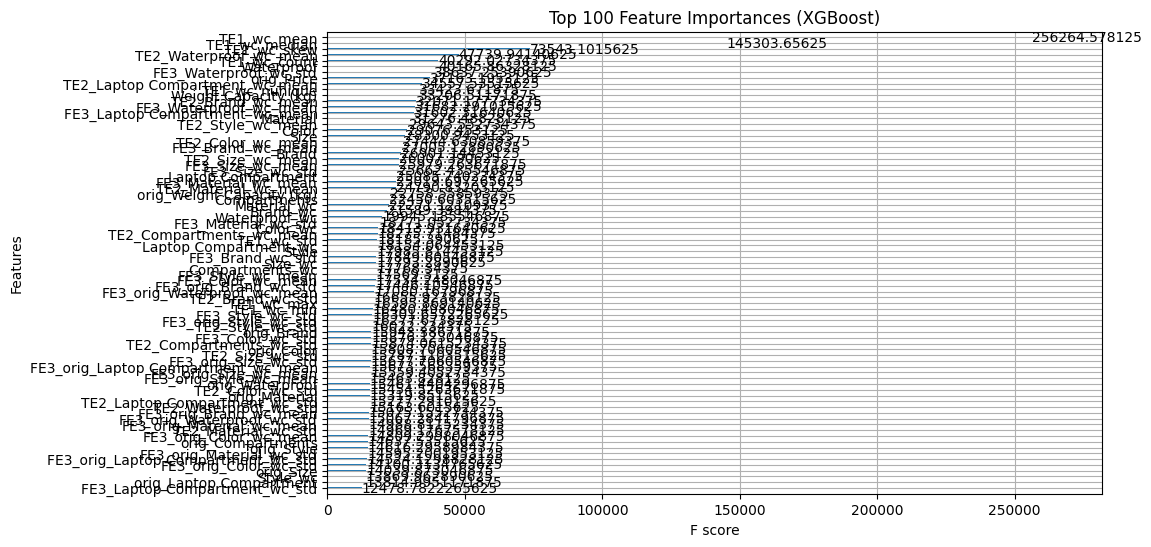

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

In [51]:
sub = pd.read_csv("./data/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_2.csv",index=False)
sub.head()

,id,Price
0,300000,79.804270
1,300001,82.580157
2,300002,86.002893
3,300003,79.469426
4,300004,79.415278
